In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

import datetime
from pandas.tseries.offsets import DateOffset
from pandas.tseries.offsets import MonthEnd

import statsmodels.api as sm
from scipy import stats
import itertools

import gc
import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv("../datasets/binance-solana.csv")

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df['Close Time'] = pd.to_datetime(df['Close Time'], format='mixed').dt.strftime('%Y-%m-%d %H:%M:%S')
df['Close Time'] = pd.to_datetime(df['Close Time'], format='%Y-%m-%d %H:%M:%S')

In [16]:
df.set_index(df['Date'], inplace=True)
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2020-08-11 09:00:00', '2020-08-11 09:15:00',
               '2020-08-11 09:30:00', '2020-08-11 09:45:00',
               '2020-08-11 10:00:00', '2020-08-11 10:15:00',
               '2020-08-11 10:30:00', '2020-08-11 10:45:00',
               '2020-08-11 11:00:00', '2020-08-11 11:15:00',
               ...
               '2023-09-22 21:45:00', '2023-09-22 22:00:00',
               '2023-09-22 22:15:00', '2023-09-22 22:30:00',
               '2023-09-22 22:45:00', '2023-09-22 23:00:00',
               '2023-09-22 23:15:00', '2023-09-22 23:30:00',
               '2023-09-22 23:45:00', '2023-09-23 00:00:00'],
              dtype='datetime64[ns]', name='Date', length=109119, freq=None)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109119 entries, 0 to 109118
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date                          109119 non-null  datetime64[ns]
 1   Open                          109119 non-null  float64       
 2   High                          109119 non-null  float64       
 3   Low                           109119 non-null  float64       
 4   Close                         109119 non-null  float64       
 5   Volume                        109119 non-null  float64       
 6   Close Time                    109119 non-null  datetime64[ns]
 7   Quote Asset Volume            109119 non-null  float64       
 8   Number of Trades              109119 non-null  int64         
 9   Taker Buy Base Asset Volume   109119 non-null  float64       
 10  Taker Buy Quote Asset Volume  109119 non-null  float64       
 11  Ignore       

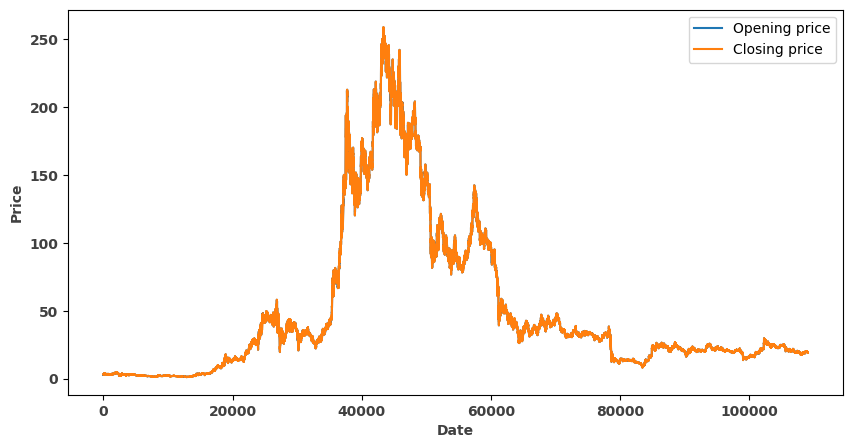

In [85]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df["Open"], label="Opening price")
plt.plot(df["Close"], label="Closing price")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

In [86]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [88]:
def sarimax_function(data,pdq,s_pdq):

    result_list = []
    for param in pdq:
        for s_param in s_pdq:

            model = sm.tsa.statespace.SARIMAX(data, order=param, seasonal_order=s_param,
            enforce_invertibility=False,enforce_stationarity=False)

            results = model.fit()
            result_list.append([param,s_param,results.aic])
            print("ARIMA Parameters: {} x: {}. AIC: {}".format(param,s_param,results.aic))

    return result_list,results


In [90]:
result_list,results = sarimax_function(df["Close"],pdq,seasonal_pdq)

gc.collect()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73724D+00    |proj g|=  1.20082D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.201D-07   5.737D+00
  F =   5.7372357475024396     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA Parameters: (0, 0, 0) x: (0, 0, 0, 12). AIC: 1252084.8550634375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2

5673

In [91]:
results_dataframe = pd.DataFrame(result_list, columns=["dpq","s_dpq","aic"]).sort_values(by="aic")
results_dataframe.head()

dpq          s_dpq            aic
57  (1, 1, 1)  (0, 0, 1, 12)  168099.130984
60  (1, 1, 1)  (1, 0, 0, 12)  168100.123876
61  (1, 1, 1)  (1, 0, 1, 12)  168101.165144
56  (1, 1, 1)  (0, 0, 0, 12)  168106.992272
59  (1, 1, 1)  (0, 1, 1, 12)  168185.585676

In [18]:
model = sm.tsa.statespace.SARIMAX(df["Close"], order=(1, 1, 1), seasonal_order=(0, 0, 1, 12),
            enforce_invertibility=False,enforce_stationarity=False).fit()
print(model.summary().tables[1])

RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70648D-01    |proj g|=  3.67323D-02

At iterate    5    f=  7.70272D-01    |proj g|=  1.30965D-03

At iterate   10    f=  7.70228D-01    |proj g|=  3.46790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.238D-05   7.702D-01
  F =  0.77021935219458459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

In [17]:
df__prediction = df[["Close"]]

df_prediction["Forcasting"] = model.get_prediction(start=pd.to_datetime("2020-08-11 09:00:00"), end=pd.to_datetime("2023-09-23"))

NameError: name 'model' is not defined